# 과제#6. 영한 번역기 과제 

- 코드 수정 내용 : 
1. Google Colab을 사용하기 위해 drive mount code를 추가하였습니다. 그리고 "구어체(1).txt"파일을 사용하기 위해 경로를 추가로 수정해주었습니다.
2.  sentecnepiece 사용을 위해 sentecepiece라이브러리를 import해주었습니다.그리고 해당 라이브러리를 이용해서 32000개의 단어를 추출해주었고, 다시 그 단어를 "구어체(2).txt" 파일에 저장해두었습니다. 아래 구어체(2).txt파일 만들기에서 코드를 확인하실 수 있습니다.

In [1]:
# mout
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# txt 파일을 불러오기 위해 디렉토리 위치 이동
import os
from pathlib import Path

# folder 변수에 구글드라이브에 프로젝트를 저장한 디렉토리를 입력하세요!
project_dir = "natural_language_processing_6"

base_path = Path("/content/drive/MyDrive/")
project_path = base_path / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/MyDrive/natural_language_processing_6


##### Copyright 2019 The TensorFlow Authors.

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation. This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"*, and return the English translation: *"are you still at home?"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 minutes to run on a single P100 GPU.

In [4]:
# sentencepiece모델 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.4 MB/s 


In [5]:
import tensorflow as tf
import sentencepiece as spm # sentecne piece 함수 사용을 위해 단어 추가 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

There are a variety of languages available, but we'll use the English-Spanish dataset. For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [6]:
# change path to bring file 구어체(1).txt
path_to_file = "/content/drive/MyDrive/natural_language_processing_6/구어체(1).txt"


## sentencepiece를 이용해서 구어체(2).txt파일 만들어주기 

In [7]:
# sentencepiece에서 32000개의 데이터를 추출하여 kor이라는 vocab모델을 만듦

spm.SentencePieceTrainer.Train('--input=구어체(1).txt --model_prefix=kor --vocab_size=32000 --model_type=bpe --max_sentence_length=9999')


In [8]:
# 복원을 위해 구어체(1).txt파일을 불러옴
import pandas as pd

word = pd.read_table('구어체(1).txt', names =['kor', 'eng'])

In [9]:
# kor.model을 로드
sp = spm.SentencePieceProcessor() 
vocab_file = "kor.model" 
sp.load(vocab_file)
# sentencepiece로 복원할 문장 리스트 저장
korean_lines= word['kor']
english_lines = word['eng']

# 문장 재생성(복원)
kor_list = []
eng_list = []
for line in korean_lines:
    new_kor = (sp.encode_as_pieces(line))
    sentence = ""
    for token in new_kor:
      sentence+=(' '+token)
    kor_list.append(sentence)
    
for line in english_lines:
    new_kor = (sp.encode_as_pieces(line))
    sentence = ""
    for token in new_kor:
      sentence+=(' '+token)
    eng_list.append(sentence)

# 문장이 재생성(복원)되었는지 확인 
for i in range(0,5):
  print(str(i+1)+"번째 기존 한국어 문장:", korean_lines[i])
  print(str(i+1)+"번째 sentencepiece로 추출해준 한국어 문장:", kor_list[i])
  print(str(i+1)+"번째 기존 영어 문장:", english_lines[i])

  print(str(i+1)+"번째 sentencepiece로 추출해준 한국어 문장:", eng_list[i])
  print()

1번째 기존 한국어 문장: 'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 앱입니다.
1번째 sentencepiece로 추출해준 한국어 문장:  ▁' B ible ▁Col oring ' 은 ▁성경 의 ▁아름다운 ▁이야기를 ▁체험 ▁할 ▁수 ▁있는 ▁컬러 링 ▁앱입니다 .
1번째 기존 영어 문장: Bible Coloring' is a coloring application that allows you to experience beautiful stories in the Bible.
1번째 sentencepiece로 추출해준 한국어 문장:  ▁Bible ▁Col oring ' ▁is ▁a ▁coloring ▁application ▁that ▁allows ▁you ▁to ▁experience ▁beautiful ▁stories ▁in ▁the ▁Bible .

2번째 기존 한국어 문장: 씨티은행에서 일하세요?
2번째 sentencepiece로 추출해준 한국어 문장:  ▁씨 티 은행 에서 ▁일 하세요 ?
2번째 기존 영어 문장: Do you work at a City bank?
2번째 sentencepiece로 추출해준 한국어 문장:  ▁Do ▁you ▁work ▁at ▁a ▁City ▁bank ?

3번째 기존 한국어 문장: 푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.
3번째 sentencepiece로 추출해준 한국어 문장:  ▁푸 리토 의 ▁베스트 셀 러는 ▁해외에서 ▁입 소 문 만으로 ▁4 차 ▁완 판을 ▁기록 하였 다 .
3번째 기존 영어 문장: PURITO's bestseller, which recorded 4th rough -cuts by words of mouth from abroad.
3번째 sentencepiece로 추출해준 한국어 문장:  ▁PU R IT O ' s ▁best se ller , ▁which ▁recorded ▁4 th ▁rough ▁- cut s ▁by ▁words ▁of ▁mo

In [10]:
# 구어체(2).txt 파일로 저장
f = open("구어체(2).txt", "w")
for i in range(len(kor_list)):
    data = kor_list[i]+'\t'+eng_list[i]+"\n"
    f.write(data)

In [11]:
# 구어체 파일 확인
word2 = pd.read_table('구어체(2).txt', names =['kor', 'eng'])
word2.head()

,kor,eng
0,▁' B ible ▁Col oring ' 은 ▁성경 의 ▁아름다운 ▁이야기를 ▁체...,▁Bible ▁Col oring ' ▁is ▁a ▁coloring ▁applica...
1,▁씨 티 은행 에서 ▁일 하세요 ?,▁Do ▁you ▁work ▁at ▁a ▁City ▁bank ?
2,▁푸 리토 의 ▁베스트 셀 러는 ▁해외에서 ▁입 소 문 만으로 ▁4 차 ▁완 판을...,"▁PU R IT O ' s ▁best se ller , ▁which ▁record..."
3,▁11 장 에서는 ▁예수님 이 ▁이번엔 ▁나 사 로를 ▁무덤 에서 ▁불러 내 어 ...,▁In ▁Ch ap ter ▁11 ▁Jesus ▁called ▁L az ar us...
4,"▁6 .5 , ▁7, ▁8 ▁사이즈가 ▁몇 ▁개나 ▁더 ▁재 입고 ▁될지 ▁제게 ...",▁I ▁would ▁feel ▁grateful ▁to ▁know ▁how ▁man...


In [12]:
# change path to bring file 구어체(2).txt
path_to_file = "/content/drive/MyDrive/natural_language_processing_6/구어체(2).txt"

## Preprocessing

In [13]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  #w = unicode_to_ascii(w.lower().strip())
  w = w.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^0-9a-zA-Z가-힣?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [14]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [15]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [16]:
#-*- coding: utf-8 -*-
ko, en = create_dataset(path_to_file, None)
print(en[80000])
print(ko[80000])

<start> when you make an order , he cooks on the steel pan right away . <end>
<start> 네가 가서 주문하면 즉 석 에서 철 판에 요리를 해줘 . <end>


In [17]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [18]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [19]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

print(num_examples, len(input_tensor), len(target_tensor))

100000 100000 100000


In [20]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [21]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [22]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
7 ----> you
156 ----> didn
20 ----> t
138 ----> even
60 ----> know
62 ----> how
7 ----> you
121 ----> re
394 ----> making
23 ----> your
355 ----> parents
1460 ----> upset
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
44 ----> 네가
377 ----> 얼마나
77 ----> 네
3546 ----> 부모
53 ----> 를
5251 ----> 화나게
769 ----> 하는지
6260 ----> 모르고
2792 ----> 있었
40 ----> 지
3 ----> .
2 ----> <end>


In [23]:
convert(inp_lang, input_tensor_train[1000])

convert(targ_lang, target_tensor_train[1000])

1 ----> <start>
32 ----> if
7 ----> you
2507 ----> delete
8 ----> a
330 ----> game
9 ----> ,
5 ----> the
498 ----> data
25 ----> will
39 ----> not
29 ----> be
3834 ----> recovered
3 ----> .
2 ----> <end>
1 ----> <start>
811 ----> 게임
2970 ----> 삭제
94 ----> 시
7314 ----> 데이터가
12080 ----> 복구
291 ----> 되지
281 ----> 않습니다
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [24]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

print(vocab_inp_size, vocab_tar_size)

9808 19225


In [25]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 59]), TensorShape([64, 48]))

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [26]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [27]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

encoder.summary()

Encoder output shape: (batch size, sequence length, units) (64, 59, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  2510848   
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
Total params: 6,449,152
Trainable params: 6,449,152
Non-trainable params: 0
_________________________________________________________________


In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [29]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 59, 1)


In [30]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [31]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))
decoder.summary()

Decoder output shape: (batch_size, vocab size) (64, 19225)
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  4921600   
                                                                 
 gru_1 (GRU)                 multiple                  7084032   
                                                                 
 dense_3 (Dense)             multiple                  19705625  
                                                                 
 bahdanau_attention_1 (Bahda  multiple                 2100225   
 nauAttention)                                                   
                                                                 
Total params: 33,811,482
Trainable params: 33,811,482
Non-trainable params: 0
_________________________________________________________________


## Define the optimizer and the loss function

In [32]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [34]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [35]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.4563
Epoch 1 Batch 100 Loss 1.7138
Epoch 1 Batch 200 Loss 1.6240
Epoch 1 Batch 300 Loss 1.5987
Epoch 1 Batch 400 Loss 1.4784
Epoch 1 Batch 500 Loss 1.6224
Epoch 1 Batch 600 Loss 1.4535
Epoch 1 Batch 700 Loss 1.5912
Epoch 1 Batch 800 Loss 1.5985
Epoch 1 Batch 900 Loss 1.7075
Epoch 1 Batch 1000 Loss 1.5046
Epoch 1 Batch 1100 Loss 1.4778
Epoch 1 Batch 1200 Loss 1.5504
Epoch 1 Loss 1.5675
Time taken for 1 epoch 4184.392882108688 sec

Epoch 2 Batch 0 Loss 1.4908
Epoch 2 Batch 100 Loss 1.3797
Epoch 2 Batch 200 Loss 1.4656
Epoch 2 Batch 300 Loss 1.2874
Epoch 2 Batch 400 Loss 1.3237
Epoch 2 Batch 500 Loss 1.3653
Epoch 2 Batch 600 Loss 1.2564
Epoch 2 Batch 700 Loss 1.1361
Epoch 2 Batch 800 Loss 1.2596
Epoch 2 Batch 900 Loss 1.2468
Epoch 2 Batch 1000 Loss 1.2083
Epoch 2 Batch 1100 Loss 1.1466
Epoch 2 Batch 1200 Loss 1.1379
Epoch 2 Loss 1.2477
Time taken for 1 epoch 4122.5248067379 sec

Epoch 3 Batch 0 Loss 0.9752
Epoch 3 Batch 100 Loss 0.9559
Epoch 3 Batch 200 Loss 1.0462


## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [36]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [37]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [38]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [39]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> it is hard to save time <end>
Predicted translation: 그것은 시간을 절약 하는 것은 어렵습니다 . <end> 


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44163 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51012 missing from current font.
  font.set_

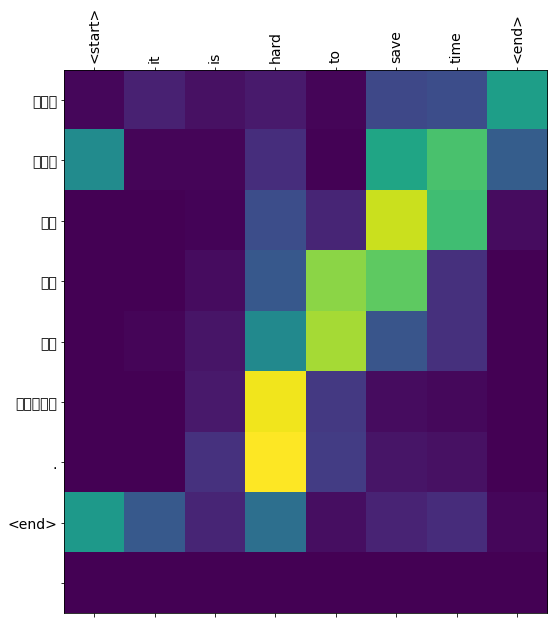

In [40]:
translate('it is hard to save time')

Input: <start> you are pretty small <end>
Predicted translation: 당신은 꽤 엄청나게 작습니다 . <end> 


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45817 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49888 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51008 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50628 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52397 missing from current font.
  font.set_

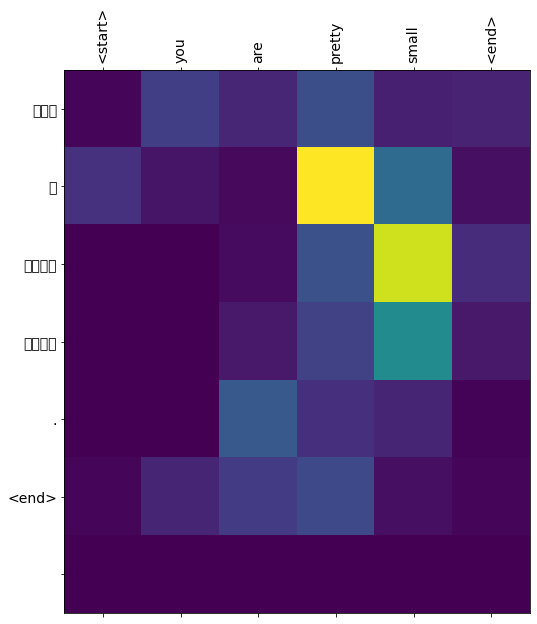

In [41]:
translate('you are pretty small')

Input: <start> why does he have long hair ? <end>
Predicted translation: 그는 왜 는 왜 이렇게 멀 나요 ? <end> 


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50780 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47111 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44172 missing from current font.
  font.set_

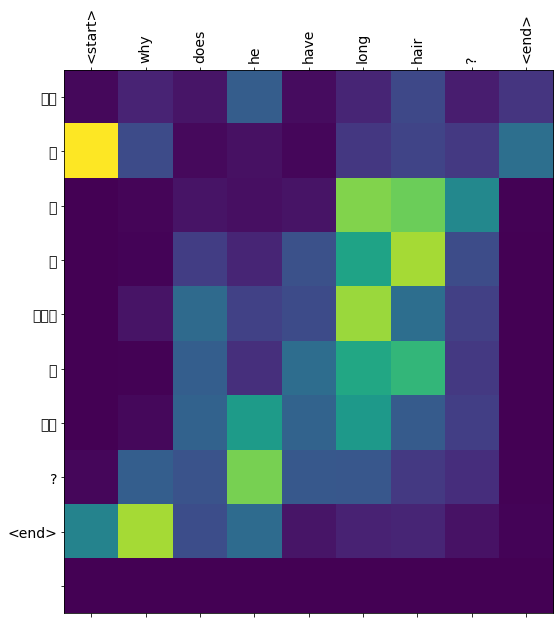

In [42]:
translate('why does he have long hair?')

Input: <start> when do we take dinner ? <end>
Predicted translation: 너는 언제 사 니 ? <end> 


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45768 missing from current font.
  font.set_

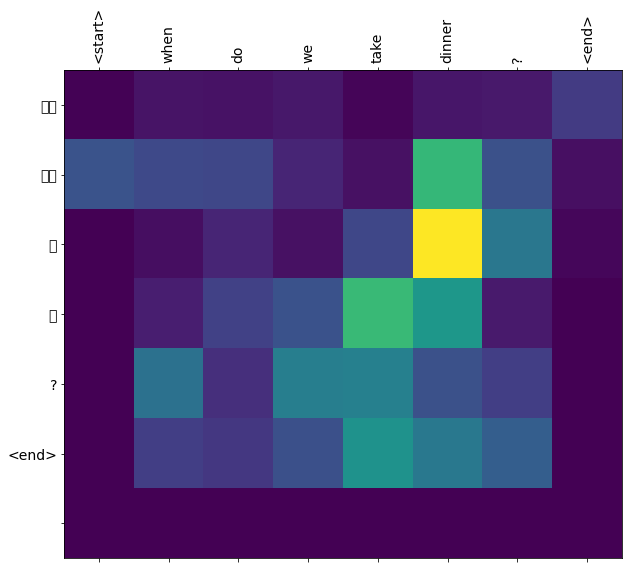

In [43]:
# wrong translation
translate('when do we take dinner?')

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs
